# Vector Expressions

## Imports and set the printer

In [1]:
import sympy as sp
# need to import the custom function to print vectors
from vector_expr_printing import vector_latex
# starting point of a vector expression is a vector symbol
from vector_expr import (VectorSymbol, VectorExpr, VectorZero, VectorOne, Nabla)
# also import symbolic vectors
from sympy.vector import CoordSys3D, Vector

In [2]:
# setting the printer to use latex_vector function
from sympy.interactive import printing
printing.init_printing(latex_printer=vector_latex)

## Expressions

Let's create a couple of symbols:

In [3]:
v1 = VectorSymbol("v_1")
v2 = VectorSymbol("v_2")
v1, v2

There are useful vectors that are defined as singletons:

In [4]:
nabla = Nabla()
zero = VectorZero()
one = VectorOne()
nabla, zero, one

Note that these three singletons are instances of `VectorSymbol`, for example:

In [5]:
isinstance(one, VectorSymbol)

True

Dot product can be achieved with `&` operator or with the method `dot`:

In [6]:
v1 & v2, v1.dot(v2), v1.dot(zero)

Dot product is going to create an object of type `VecDot`:

In [7]:
type(v1 & v2)

vector_expr.VecDot

Cross product can be achieved with `^` operator or with the method `cross`:

In [8]:
v1 ^ v2, v1.cross(v2), v1 ^ v1, v1 ^ zero

Cross product is going to create an object of type `VecCross`:

In [9]:
type(v1 ^ v2)

vector_expr.VecCross

`VecDot` and `VecCross` instances expose the property reverse:

In [10]:
(v1 & v2).reverse, (v1 ^ v2).reverse

To sum or subtract two or more vectors:

In [11]:
s = v1 + v2 - one
s

Addition is going to create an object of type `VecAdd`:

In [12]:
type(s)

vector_expr.VecAdd

There are other methods and properties that we can use, namely:
* `mag` as an alias for `magnitude()`;
* `norm` as an alias for `normalize()`, to return a unit vector;
* `div` as an alias for `divergence()`;
* `curl()`;

Note the types of the returned objects:

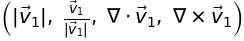

<class 'vector_expr.Magnitude'>
<class 'vector_expr.Normalize'>
<class 'vector_expr.VecDot'>
<class 'vector_expr.VecCross'>


In [13]:
p = (v1.mag, v1.norm, v1.div, v1.curl())
display(p)
for e in p:
    print(type(e))

Here `Normalize` represents an unevaluated unit vector: what we are seeing is effectively one object, even if it has been rendered as a fraction! It is also possible to change its rendering to obtain $\hat{v}_{1}$ (note the hat) by passing arguments to the function `vector_latex`: we will see later how to achieve that.

It is worth mentioning that we can evaluate the `Normalize` object: at creation time by passing the flag `evaluate=True` to the constructor, or after it has been created by calling the method `doit()`. For example:

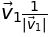

VecMul(VectorSymbol(Symbol('v_1')), VecPow(Magnitude(VectorSymbol(Symbol('v_1'))), Integer(-1)))


In [14]:
n = v1.norm.doit()
display(n)
print(sp.srepr(n))

As we can see, we have created an expression containing a fraction where it's denominator represent the magnitude, all multiplied by the original vector.

Note the use of `VecPow` to represent the fraction, similar to Sympy expressions.

Note that `VectorSymbol`, `VecAdd`, `VecCross`, `VecDot`, `VecPow`, ..., are all instances of `VectorExpr`.

In [15]:
isinstance(v1, VectorExpr)

True

From the operations above, you may be thinking that the methods and properties previously introduced are defined in the `VectorSymbol` class: that's wrong, they are defined in the `VectorExpr` class! This allows us to do more convoluted operations:

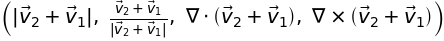

In [16]:
expr = v1 + v2
expr.mag, expr.norm, expr.div, expr.curl()

Here we can also appreciate the reasoning behind the default rendering of `Normalize`: if we were to use the default symbol for unit vectors (the hat) it would have looked awful.

When we think about dot products and magnitudes, they produce scalar results. Nonetheless, they are considered vector expressions.

It is possible to combine different operations together, though they must obey the vector operations rules. For example, it is perfectly legit to add two vectors together: 

In [17]:
v1 + v2

However, it is not possible to add a vector and a scalar:

In [18]:
v1 + 2

TypeError: Mix of Vector and Scalar symbols

If we wish to add a scalar to all the components of the vector, we can use:

In [19]:
v1 + 2 * one

We can also add different scalar components together:

In [20]:
s = v1.mag + v2.mag
display(s)
print(type(s))

<class 'vector_expr.VecAdd'>


As we can see, we still have a vector expression!

Note that at this point we must be careful about the precedence of the operations. For instance, we might be thinking that the following expression would work:

In [21]:
v1.mag + v1 & v2 + 4

TypeError: Mix of Vector and Scalar symbols

However, at this point of development `v1.mag + v1` has the precedence over `v1 & v2`, therefore `v1.mag + v1` is a mix between scalar and vector symbols. To perform this kind of operations, we better use parentheses:

In [22]:
expr = v1.mag + (v1 & v2) + 4
expr

We have seen that vector expressions may contains vectors or results of operations over vectors. We can use the property `is_Vector` to verify if a vector expression contains vectors or scalars. For example:

In [23]:
expr = v1 + v2
expr.is_Vector

True

In [24]:
expr = v1.mag + (nabla & v2)
expr.is_Vector

False

## Evaluation

Say we finally developed out vector expressions and we would like to insert actual vectors (with their respective components). We create the vector from the module `sympy.vector`:

In [25]:
C = CoordSys3D("C")
a, b = sp.symbols("a, b", real=True)
vn1 = 4 * C.x * C.i + C.j + a * C.z * C.k
vn2 = (a**2 + b) * C.j + 2 * C.k
vn1, vn2

Then we use the method `subs()`:

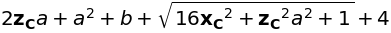

In [26]:
expr = v1.mag + (v1 & v2) + 4
expr.subs({v1: vn1, v2: vn2}).doit()

Note however that we must be careful in what we are doing, for example:

In [27]:
expr = one & v1
expr
expr.subs({v1: vn1}).doit()

You may be wondering why the expression has not been fully evaluated. That's because every vector need a reference system, even the unit vector. But the symbolic `VectorOne` is just a symbol, it doesn't have any specific reference system. To fully evaluate the previous expression, we need to create a one vector:

In [28]:
oneC = C.i + C.j + C.k
expr.subs({v1: vn1, one: oneC}).doit()

Look at what happens if we use a one-vector from a different reference system:

In [29]:
R = CoordSys3D("R")
oneR = R.i + R.j + R.k
expr.subs({v1: vn1, one: oneR}).doit()